In [1]:
from __future__ import division
import numpy as np 
import cPickle
from tqdm import tqdm
from matplotlib import pyplot as plt 

# Get the CIFAR data

In [2]:
def load_cifar_data(N=1000, D=10):
    def unpickle( file ):
        fo = open(file, 'rb')
        dict = cPickle.load(fo)
        fo.close()
        return dict

    data = unpickle( 'cifar-10-batches-py/data_batch_1' )

    features = data['data']
    labels = data['labels']
    labels = np.atleast_2d( labels ).T

    # only keep N items
    features = features[ 0:N, : ] 
    labels = labels[ 0:N, : ]

    # project down into a D-dimensional space
    features = np.dot( features, np.random.randn( 3072, D) )

    # whiten our data - zero mean and unit standard deviation
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

    return features, labels

# A 1-Layer Neural Network with Back Propagation

In [7]:
class GradientDescent(object):
    def __init__(self, features, labels, num_epochs, step_size=0.1):
        """
        A class which runs a 1-layer neural network on an input dataset, 
        and uses gradient descent to maximize the accuracy.
        """

        self.features = features 
        self.labels = labels

        m, n = np.shape(features)

        self.W = 1e-3 * np.random.randn(n,n)

        self.num_epochs = num_epochs

        self.step_size = step_size

    def softmax_loss_function(self): 
        """
        Algorithm:
            1. exp-normalize trick: step1 = (exp(scores - max(scores, axis=0/1)) / sum(exp(scores - max(scores, axis=0/1)), axis=0/1))
            2. all_loss_values = -log10(step1)
            3. L_i = all_loss_values[true_labels]
            4. final_loss = np.mean(L_i) #Don't take sum because it gets too big.
        """

        scores = np.dot(self.W, self.features.T)
        beta = np.max(scores, axis=0)
        axis=0
        step1 = np.exp(scores - beta) / np.sum(np.exp(scores - beta), axis=axis) #good. 

        all_loss_values = -np.log10(step1)
        L_i = [i[self.labels[ind]] for ind, i in enumerate(all_loss_values.T)]

        return np.mean(L_i)

    def numerical_gradient(self, h=1e-06): 
        """
        Calculate the derivative numerically for each element of W, fill the gradient.

        Return the gradient and the loss.
        """

        #We need something to compare it to.
        original_loss = self.softmax_loss_function()

        #Initialize an empty gradient matrix, which we will fill.
        gradient = np.zeros_like(self.W)

        #We will fill up the gradient for each element of self.W
        for row_num, row in enumerate(self.W):
            for col_num, column in enumerate(row):
                original_weight = self.W[row_num, col_num]
                #Perturb W a little bit
                self.W[row_num, col_num] += h

                #Get the new loss
                new_loss = self.softmax_loss_function()
                #Put it in the gradient.
                gradient[row_num, col_num] = (new_loss - original_loss) / h
                #Put W back the way it was.
                self.W[row_num, col_num] = original_weight


        return gradient, original_loss

    def update_accuracy(self):
        """
        algorithm:
            1. score = get_scores()
            2. probabilities = get_probabilities(), which is the same as step1 from softmax_loss_function.
            3. guesses = argmax(probabilities, axis=0)
            4. accuracy = mean(guesses==labels)
        """
        scores = np.dot(self.W, self.features.T)

        guesses = np.argmax(scores, axis=0)
        
#         accuracy = (np.mean(np.atleast_2d(guesses) == np.atleast_2d(self.labels)))
        
        accuracy = np.sum(np.atleast_2d(guesses).T == self.labels) / self.labels.shape[0]
        
        return accuracy

    def update_W(self, grad):
        self.W = self.W - self.step_size*grad

    def fit(self):
        """
        Algorithm:
            1. for i in epochs:
                2. grad, loss = numerical_gradient
                3. update_w
                4. append to all_losses
                5. apppend to all_accuracies

            6. plot all_losses
            7. plot all_accuracies
        """

        all_losses, all_accuracies = [], []
        for iternum in tqdm(xrange(self.num_epochs)):
            grad, loss = self.numerical_gradient()
            accuracy = self.update_accuracy()

            all_losses.append(loss)
            all_accuracies.append(accuracy*100)

            self.update_W(grad)

        #Now plot the accuracy and the loss.
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        plt.plot(all_accuracies, 'b')
        plt.title('Accuracy')
        plt.xlabel('Epoch Number')
        plt.ylabel('Percent Accuracy (%)')

        plt.subplot(212)
        plt.plot(all_losses, 'r')
        plt.title('Loss')
        plt.xlabel('Epoch Number')
        plt.ylabel('Loss')

# Now run the Perceptron on the CIFAR-10 dataset

100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


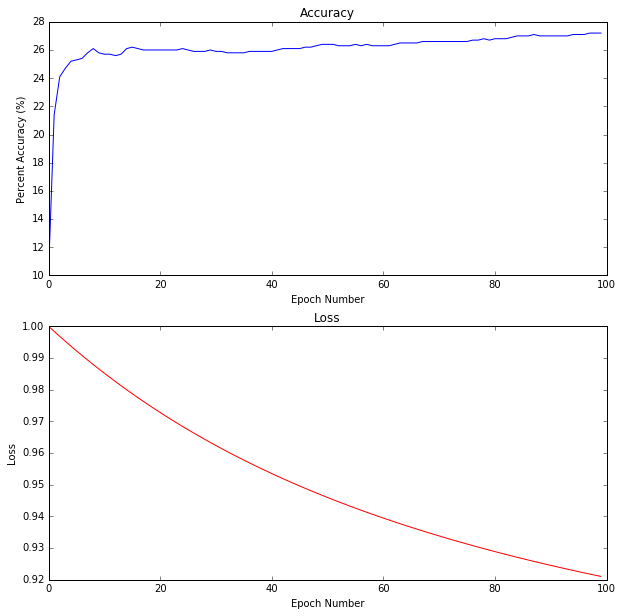

In [6]:
f, l = load_cifar_data()
NUM_EPOCHS = 100

G = GradientDescent(f, l, NUM_EPOCHS)

G.fit()
plt.show()